# Tutorial: creating a Q2Q transform step by step

A Q2Q transform is a functional relationship between what you have and what you would like to have. It applies to random variables, because the relationship is between the quantiles of the input and the target random variables.

In this context, this tutorial shows how to generate Q2Q functions between modelled (input) and historical (target) renewable generation time series, for solar and onshore wind power. Unless stated otherwise, hourly time series for one year will be considered.

This Q2Q encapsulates the modelling errors in a statistical sense, and can be used to improve the modelling of renewable generation in tasks related to energy system optimisation. Further details can be found at https://arxiv.org/abs/2412.06571.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import sys
import os
import numpy as np



##### Import local functions
sys.path.append(os.path.abspath(os.path.join('..')))
import funs

## Gather your data

To implement a Q2Q transform, you basically need two time series:

- the target time series, with historical data, $g_{H,t}$, for a specific year of interest.

- the input time series, with modelled data, $g_{M,t}$, for the same time period.

$t$ refers to time index.

### Historical data

> At the end of this section, the dataframe `df_target` with the input time series must be defined. Indices must be timestamps in UTC, and the column name must be `value`.

Obtaining historical data of renewable generation can be difficult, if not impossible.

Generation time series for Spain can be retrieved at https://api.esios.ree.es/.

This repository includes historical generation time series for Spain for several years in folder `data/historical_data/`

In [21]:
##### Parameters
carrier = 'onwind'
year = 2023


##### Load target data
df_target = pd.read_csv(f'../data/historical_data/{carrier}_{year}.csv',
                        index_col=0, parse_dates=True)

### Modelled data

> At the end of this section, the dataframe `df_input` with the input time series must be defined. Indices must be timestamps in UTC, and the column name must be `value`.

Wind and solar time series at national level can be modelled with [PyPSA-Eur](https://github.com/PyPSA/pypsa-eur). Here we will use the Spanish extension of this model, [PyPSA-Spain](https://github.com/cristobal-GC/pypsa-spain).

For modelling accuracy, it is important to use an installed capacity layout for the considered technology that is as close as possible to the existing one in the specified year. In **PyPSA-Spain** you can use the functionality `update_elec_capacities` to impose the installed capacity for a specific technology at NUTS 2 level. The data of the installed capacity in Spain at NUTS 2 level can be retrieved at https://www.ree.es/es/apidatos.




It is also important to retain all relevant details and hypotheses of the implemented scenario, as different choices may lead to different generation time series. For example:

- Source of meteorological data

- Wind turbine model / PV panel configuration

- Correction factors

- ...





This repository includes modelled generation time series for Spain for several years in folder `data/historical_data/`. Each file is in the form: 

> {carrier}\_{cutout}\_{year}\_{clustering}.csv


In [22]:
##### Parameters
cutout = 'iberia'
clustering = 'NUTS3'


##### Load input data
df_input = pd.read_csv(f'../data/modelled_data/{carrier}_{cutout}_{year}_{clustering}.csv',
                        index_col=0, parse_dates=True)

## Compare input and target variables

### Time series

In [23]:
##### Define the date range
start = f'{year}-04-01'
end = f'{year}-04-10'

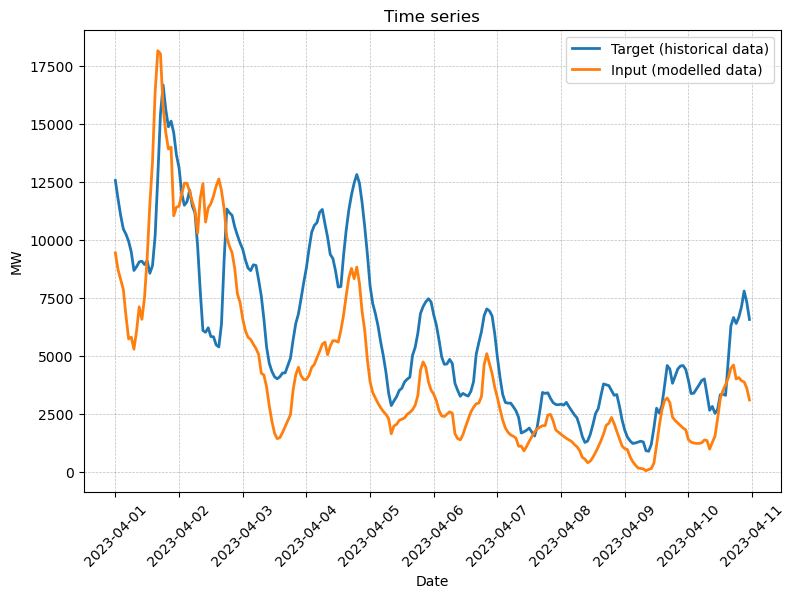

In [24]:
##### Figure
fig, ax = plt.subplots(1,1,figsize=(9,6))

ax.plot(df_target.loc[start:end].index, 
        df_target.loc[start:end]['value'], 
        label='Target (historical data)', 
        linewidth=2)

ax.plot(df_input.loc[start:end].index, 
        df_input.loc[start:end]['value'], 
        label='Input (modelled data)', 
        linewidth=2)

ax.set_title('Time series')
ax.set_xlabel('Date')
ax.set_ylabel('MW')
ax.tick_params(axis='x', labelrotation=45)
ax.legend()
ax.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)

### *pdf*s

In [25]:
##### Define the range of values
x_max = 1.05*max([df_target.max().max(), df_input.max().max()])
x_min = -0.02*x_max
N = 1000
x_values = np.linspace(x_min, x_max, N)

In [26]:
##### Input pdf
kde_input = gaussian_kde(df_input['value'])
kde_input.set_bandwidth(bw_method=kde_input.factor * 0.5)  # re-scale bandwidth

pdf_input = kde_input(x_values)

In [27]:
##### Target pdf
kde_target = gaussian_kde(df_target['value'])
kde_target.set_bandwidth(bw_method=kde_target.factor * 0.5)  # re-scale bandwidth

pdf_target = kde_target(x_values)

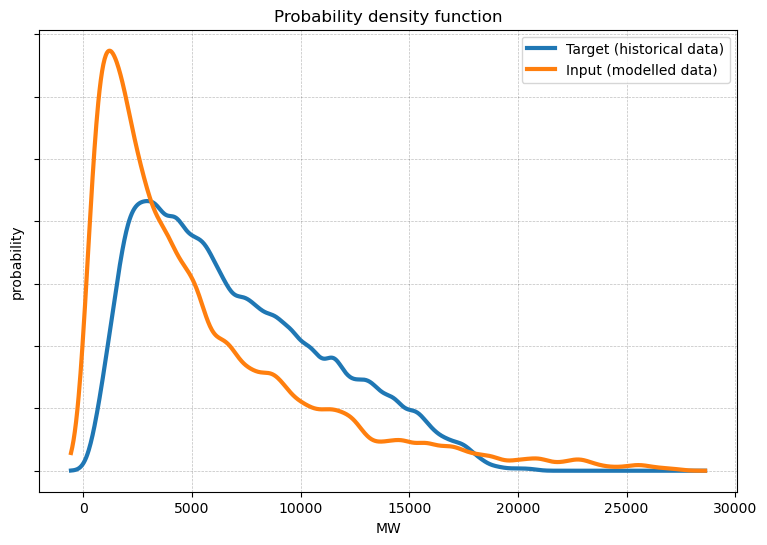

In [28]:
##### Figure
fig, ax = plt.subplots(1,1,figsize=(9,6))

ax.plot(x_values, pdf_target, label='Target (historical data)', linewidth=3)
ax.plot(x_values, pdf_input, label='Input (modelled data)', linewidth=3)

ax.set_title('Probability density function')
ax.set_xlabel('MW')
ax.set_ylabel('probability')
ax.set_yticklabels([])
ax.legend()
ax.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)


### Duration curves

In [29]:
##### Duration curves
sorted_target = df_target['value'].sort_values(ascending=False).reset_index(drop=True)
sorted_input = df_input['value'].sort_values(ascending=False).reset_index(drop=True)

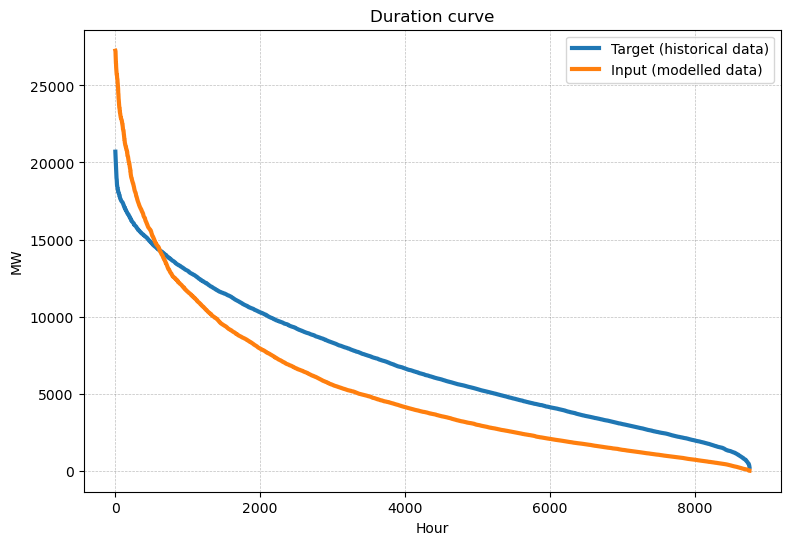

In [30]:
##### Figure
fig, ax = plt.subplots(1,1,figsize=(9,6))

ax.plot(sorted_target.values, label='Target (historical data)', linewidth=3)
ax.plot(sorted_input.values, label='Input (modelled data)', linewidth=3)

ax.set_title('Duration curve')
ax.set_xlabel('Hour')
ax.set_ylabel('MW')
ax.legend()
ax.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)


### target-vs-input

Use colours according to date to reveal potential seasonalities.

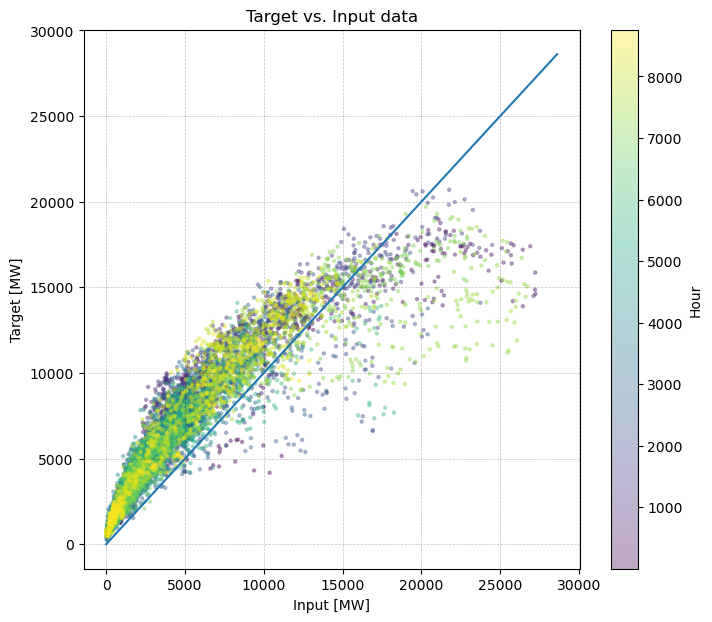

In [31]:
##### Figure
fig, ax = plt.subplots(1,1,figsize=(8,7))

color_values = range(1, len(df_input) + 1)

plt.scatter(df_input['value'], df_target['value'], 
            c=color_values,
            s = 5,
            alpha=0.35)

ax.set_title('Target vs. Input data')
ax.set_xlabel('Input [MW]')
ax.set_ylabel('Target [MW]')
ax.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)

# Colorbar
plt.colorbar(label='Hour')

# Line at 45º
x_max = 1.05*max([df_input.max().max(),df_target.max().max()])
plt.plot([0, x_max],[0, x_max])



## Normalise input and target variables

Both input and target time series are normalised before computing the Q2Q transform. Because the aim here is to obtain a transform obtained at national level to apply it at a local level (Voronoi cell), three normalisation schemes are here proposed (see https://arxiv.org/abs/2412.06571 for details):


- **Normalisation scheme (1)**:
      normalise both with the installed capacity.

- **Normalisation scheme (2)**:
      normalised both input and target with the maximum value attained by both 
      of them.

- **Normalisation scheme (3)**:
      normalise input with its maximum and target with its maximum.



In [32]:
########## Normalisation scheme (1)
df_capacity = pd.read_csv('../data/installed_capacity.csv', index_col='year')
installed_capacity = df_capacity.at[year, carrier]

df_input_norm1 = df_input.div(installed_capacity)
df_target_norm1 = df_target.div(installed_capacity)

In [33]:
########## Normalisation scheme (2)
x_max = max([df_input.max().max(),df_target.max().max()])

df_input_norm2 = df_input.div(x_max)
df_target_norm2 = df_target.div(x_max)

In [34]:
########## Normalisation scheme (3)
input_max = df_input.max().max()
target_max = df_target.max().max()

df_input_norm3 = df_input.div(input_max)
df_target_norm3 = df_target.div(target_max)    

Have a look at the impact of the normalisation scheme on the *pdf*s and the duration curves.

In [35]:
dict_dfs = {
    'df_input_norm1': df_input_norm1,
    'df_input_norm2': df_input_norm2,
    'df_input_norm3': df_input_norm3,
    'df_target_norm1': df_target_norm1,
    'df_target_norm2': df_target_norm2,
    'df_target_norm3': df_target_norm3,
}

### *pdf*s

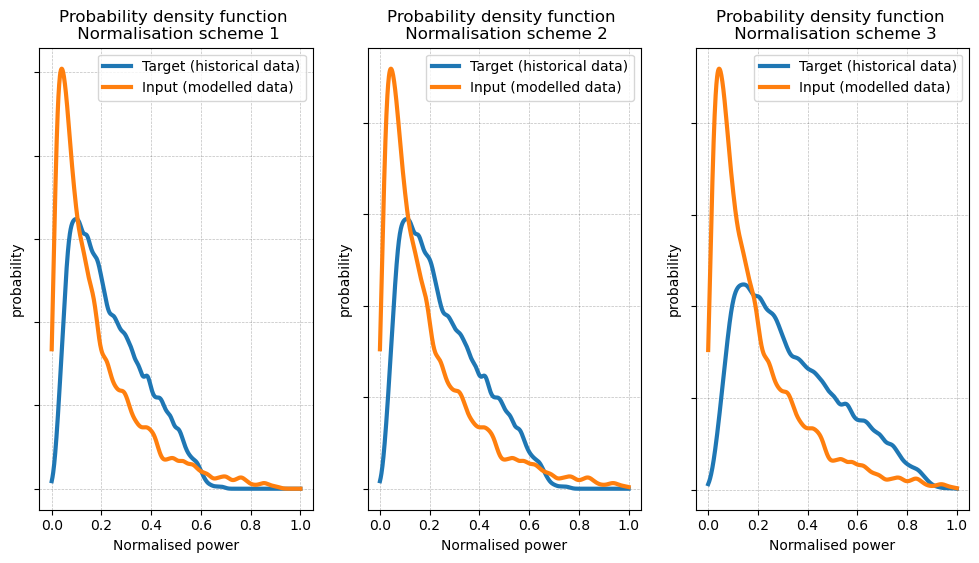

In [36]:
fig, axes = plt.subplots(1,3,figsize=(12,6))


for i, ax in enumerate(axes):

    df_input = dict_dfs[f'df_input_norm{i+1}']
    df_target = dict_dfs[f'df_target_norm{i+1}']


    ##### Define the range of values
    x_max = 1
    x_min = 0
    N = 1000
    x_values = np.linspace(x_min, x_max, N)

    ##### Input pdf
    kde_input = gaussian_kde(df_input['value'])
    kde_input.set_bandwidth(bw_method=kde_input.factor * 0.5)  # re-scale bandwidth

    pdf_input = kde_input(x_values)

    ##### Target pdf
    kde_target = gaussian_kde(df_target['value'])
    kde_target.set_bandwidth(bw_method=kde_target.factor * 0.5)  # re-scale bandwidth

    pdf_target = kde_target(x_values)

    ##### Figure
    ax.plot(x_values, pdf_target, label='Target (historical data)', linewidth=3)
    ax.plot(x_values, pdf_input, label='Input (modelled data)', linewidth=3)

    ax.set_title(f'Probability density function \n Normalisation scheme {i+1}')
    ax.set_xlabel('Normalised power')
    ax.set_ylabel('probability')
    ax.set_yticklabels([])
    ax.legend()
    ax.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)



### Duration curves

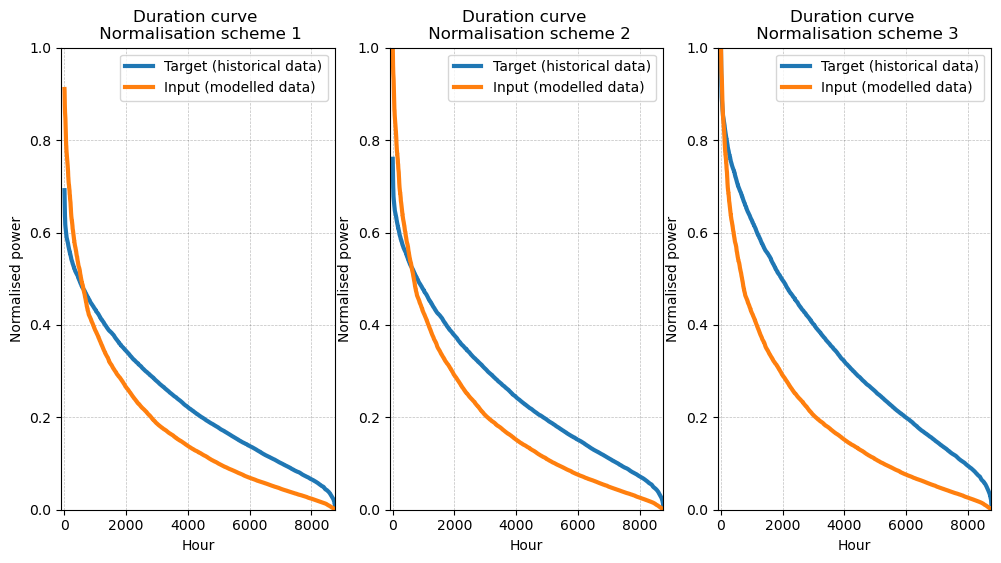

In [37]:
fig, axes = plt.subplots(1,3,figsize=(12,6))


for i, ax in enumerate(axes):

    df_input = dict_dfs[f'df_input_norm{i+1}']
    df_target = dict_dfs[f'df_target_norm{i+1}']


    ##### Duration curves
    sorted_target = df_target['value'].sort_values(ascending=False).reset_index(drop=True)
    sorted_input = df_input['value'].sort_values(ascending=False).reset_index(drop=True)

    ##### Figure
    ax.plot(sorted_target.values, label='Target (historical data)', linewidth=3)
    ax.plot(sorted_input.values, label='Input (modelled data)', linewidth=3)

    ax.set_title(f'Duration curve \n Normalisation scheme {i+1}')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Normalised power')
    ax.legend()
    ax.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)

    ax.set_xlim(-100, 8760)
    ax.set_ylim(0, 1)


## Compute the Q2Q transform

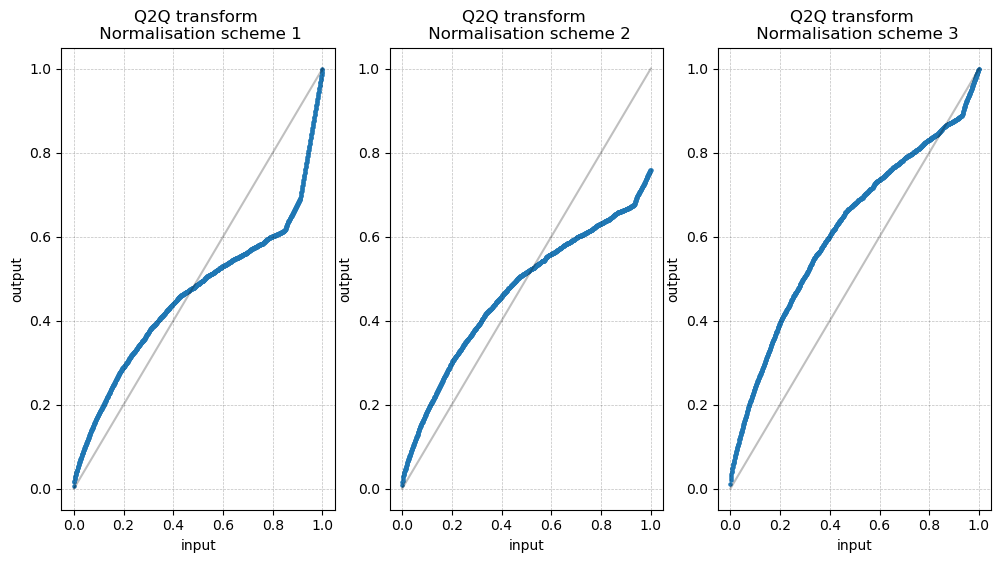

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(12,6))


for i, ax in enumerate(axes):

    ##### Select data
    df_input = dict_dfs[f'df_input_norm{i+1}']
    df_target = dict_dfs[f'df_target_norm{i+1}']


    ##### Get the Q2Q transform
    q2q_transform = funs.fun_q2q_transform(df_input, df_target)


    ##### Plot the Q2Q transform
    x_values = np.linspace(0, 1, 1000)
    y_values = q2q_transform(x_values)

    ax.scatter(x_values,y_values,s=5)
    ax.plot([0, 1],[0, 1],color='black',alpha=0.25)

    ax.set_title(f'Q2Q transform \n Normalisation scheme {i+1}')
    ax.set_xlabel('input')
    ax.set_ylabel('output')
    ax.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)